<a href="https://colab.research.google.com/github/glangan/energyDL/blob/main/Time_Series_with_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time series analysis of electricity consumption using Deep Learning

This is an hourly electricity consumption data with 8784 records for the whole 2016 year. The energy consumption is retrieved from smart metering device from a commercial-type consumer and the environmental temperature is recorded by the meteorological sensors of a specialized institute for the whole year 2016.

In [7]:
!pip install -q pmdarima

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set_palette("muted")

## Data Preprocessing

In [10]:
# Load data
df = pd.read_csv('https://raw.githubusercontent.com/glangan/energyDL/main/energy_consumption_levels.csv')
df.head()

,3_levels,5_levels,7_levels,consumption,temperature,hour_of_day,day_of_week,day_of_month,month_of_year
0,1,1,1,0.255,-6.0,1,5,1,1
1,1,1,1,0.264,-6.9,2,5,1,1
2,1,1,1,0.253,-7.1,3,5,1,1
3,1,1,1,0.250,-7.2,4,5,1,1
4,1,1,1,0.234,-7.5,5,5,1,1


In [11]:
# Convert into time series
df['date'] = pd.to_datetime(dict(year = 2016,
                                   month = df.month_of_year,
                                   day = df.day_of_month,
                                   hour = df.hour_of_day))
df.set_index(df.date, inplace = True)
df = df.drop(['3_levels', '5_levels', '7_levels', 'hour_of_day',
                  'day_of_week', 'day_of_month', 'month_of_year', 'date'],
                 axis = 1)
df.head()

,consumption,temperature
date,,
2016-01-01 01:00:00,0.255,-6.0
2016-01-01 02:00:00,0.264,-6.9
2016-01-01 03:00:00,0.253,-7.1
2016-01-01 04:00:00,0.250,-7.2
2016-01-01 05:00:00,0.234,-7.5


## Visualisations

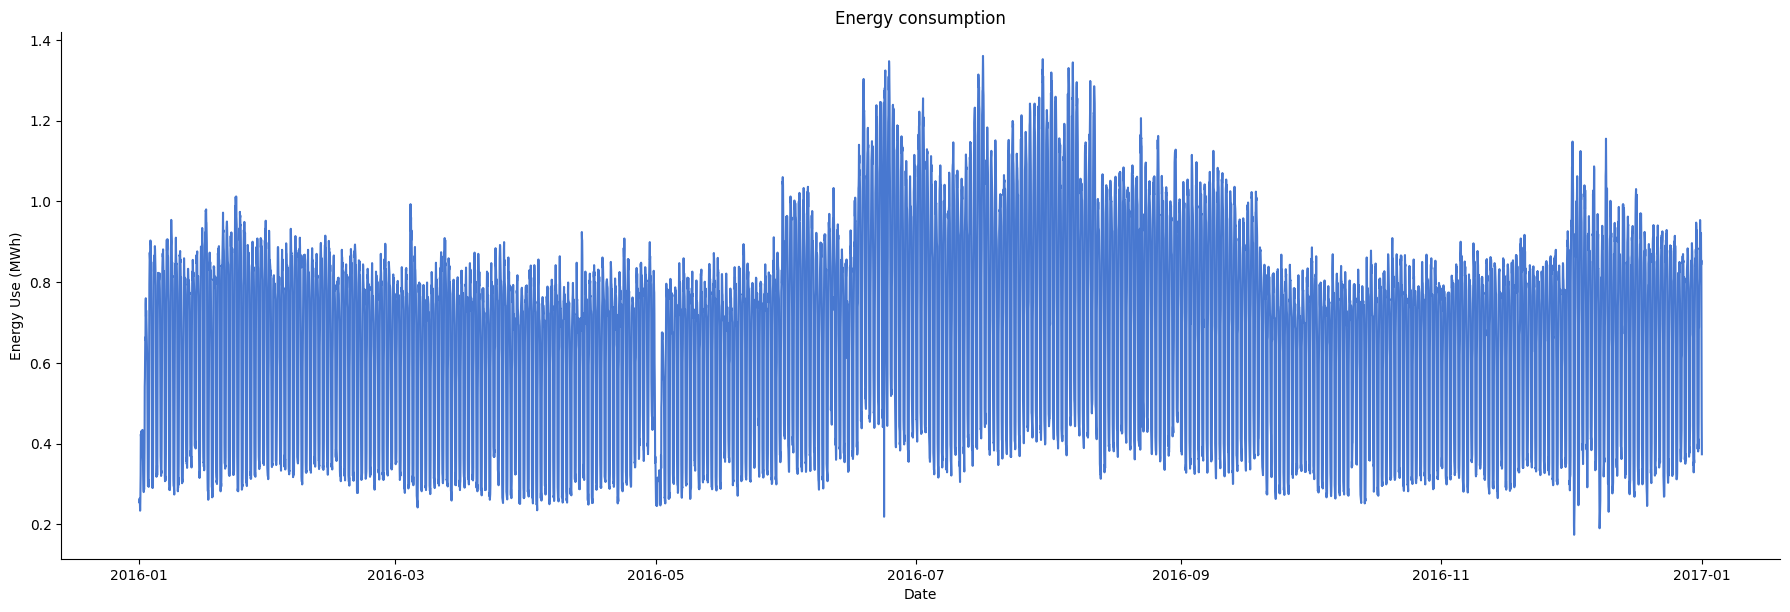

In [ ]:
# Plot consumption level
sns.relplot(x = df.index, y = 'consumption', data = df,
            kind = 'line', height = 6, aspect = 3).set(
                title="Energy consumption",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")

The time series plot for energy consumption data shows that the consumption goes up at around mid-year. There is more variablity in consumption at the end of the year.

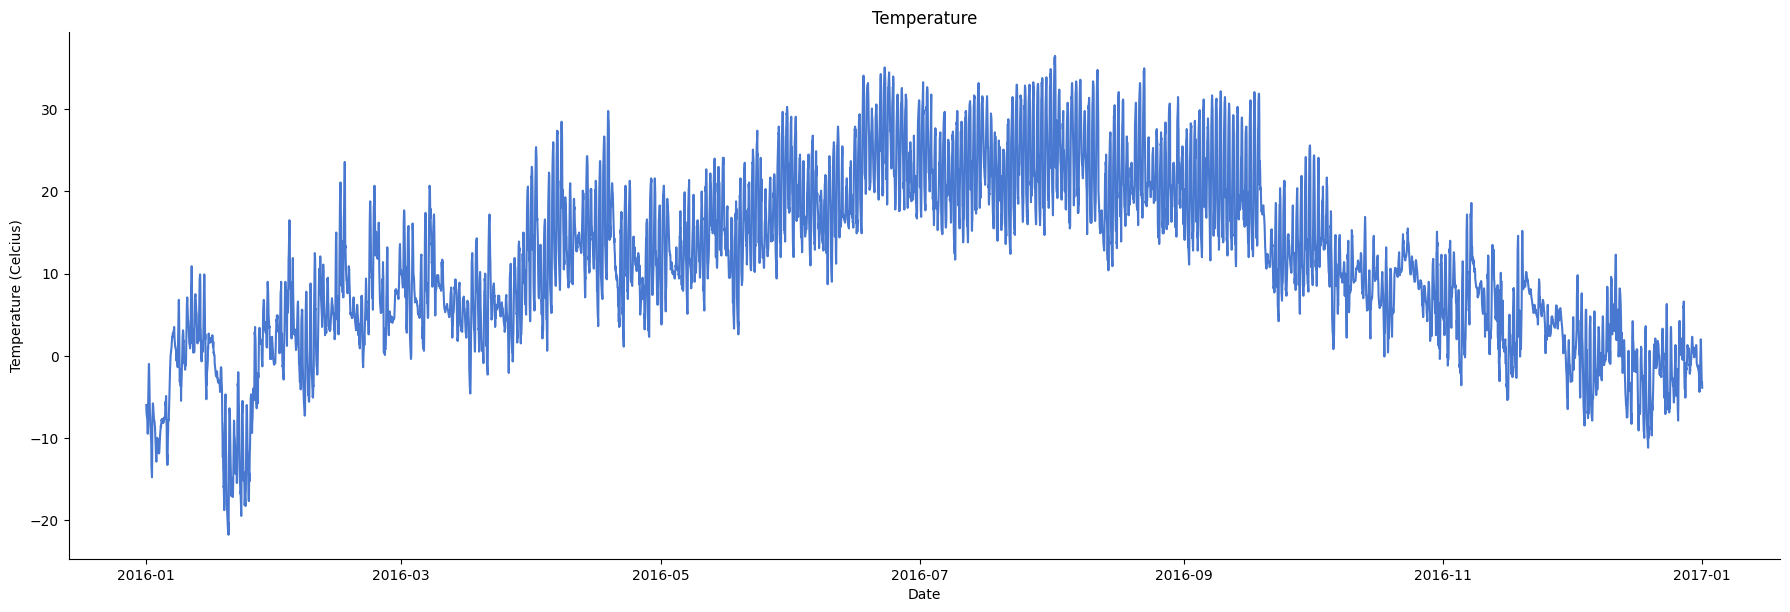

In [ ]:
# Plot temperature
sns.relplot(x = df.index.values, y = 'temperature', data = df,
            kind = 'line', height = 6, aspect = 3).set(
                title="Temperature",
                xlabel = "Date",
                ylabel = "Temperature (Celcius)")

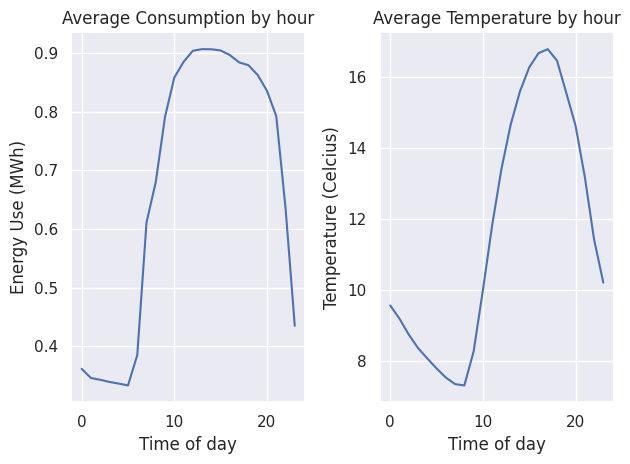

In [ ]:
# Average consumption by hour
data_hour = df.groupby(df.index.hour).mean()

sns.set()
fig, axes = plt.subplots(1, 2)

sns.lineplot(x = data_hour.index, y = 'consumption',
             data=data_hour, ax=axes[0]).set(
    title="Average Consumption by hour",
    xlabel="Time of day",
    ylabel="Energy Use (MWh)")

sns.lineplot(x = data_hour.index, y = 'temperature',
             data = data_hour, ax=axes[1]).set(
    title="Average Temperature by hour",
    xlabel="Time of day",
    ylabel="Temperature (Celcius)")

fig.tight_layout()

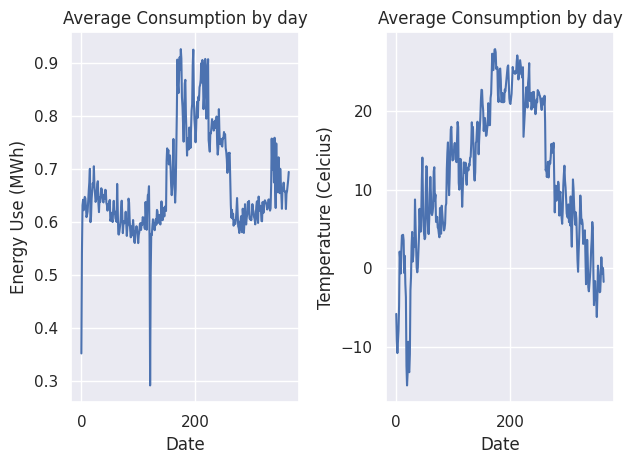

In [ ]:
# Average consumption by day
data_day = df.groupby(by=[df.index.month, df.index.day]).mean()
data_day.index.names = ['date', 'month']
data_day.reset_index(level = ['month', 'date'], inplace = True)

sns.set()
fig, axes = plt.subplots(1, 2)

sns.lineplot(x = data_day.index, y = 'consumption',
             data=data_day, ax=axes[0]).set(
    title="Average Consumption by day",
    xlabel="Date",
    ylabel="Energy Use (MWh)")

sns.lineplot(x = data_day.index, y = 'temperature',
             data = data_day, ax=axes[1]).set(
    title="Average Consumption by day",
    xlabel="Date",
    ylabel="Temperature (Celcius)")

fig.tight_layout()

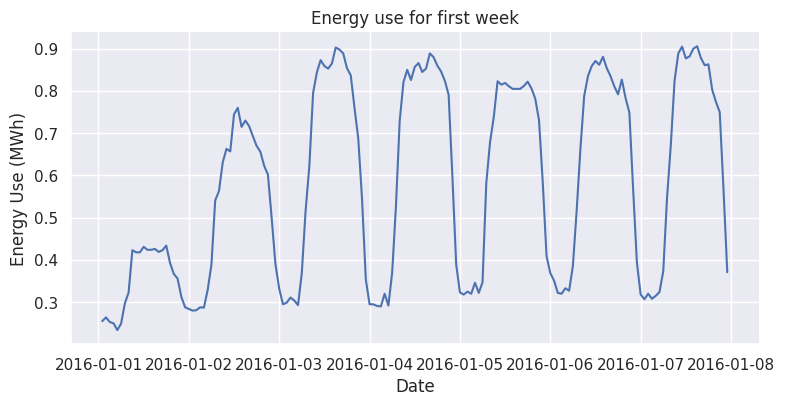

In [ ]:
# plot first week of data
week = df.iloc[:167, 0]

sns.relplot(x = week.index, y=week.values, data = week,
            kind = 'line', height = 4, aspect = 2).set(
                title="Energy use for first week",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")

## ARIMA

We start by plotting the autocorrelation and partial autocorrelation for the consumption data. The ACF plot shows that there is a autocorrelation in the data and differencing may be required.

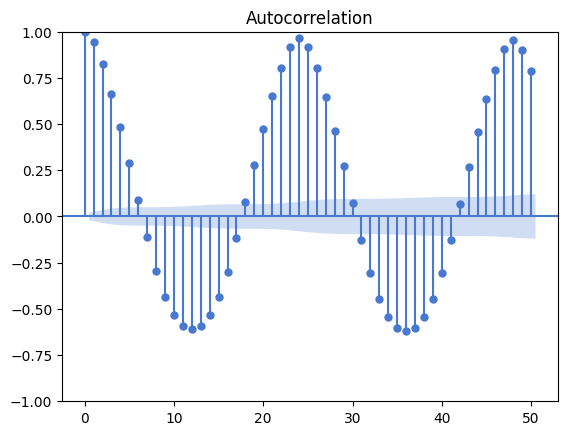

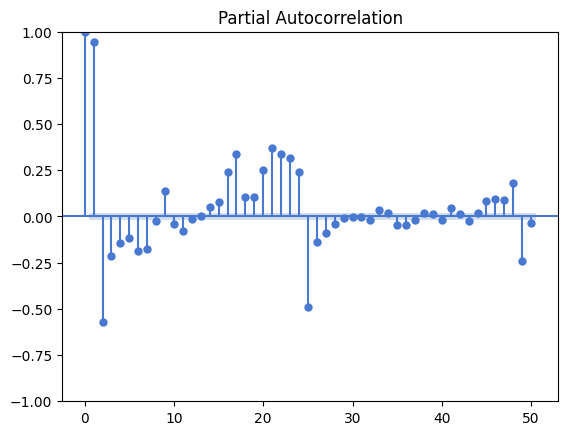

In [14]:
# ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

cons = df['consumption']
plt_acf = plot_acf(cons, lags = 50)
plt_pacf = plot_pacf(cons, lags = 50)

To develop and test a ARIMA model, we first split the data into train and test set. In the first step, we take the data for the last two months as the test set. We then use a grid search for the best parameters for ARIMA model. The criteria used to find the optimum parameters is the minimum AIC.

In [38]:
# Train test split
# Test data - last 2 months

cons_train_2m = cons[:7320]
cons_test_2m = cons[7320:]

In [35]:
# Grid search
auto_arima(cons_train_2m, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-17756.576, Time=22.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14774.523, Time=0.69 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17143.679, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16458.691, Time=2.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14776.522, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-17213.317, Time=7.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-17210.101, Time=3.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-17534.990, Time=17.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-17220.202, Time=18.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-17207.026, Time=7.79 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-17214.553, Time=15.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-17208.209, Time=5.88 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-17512.633, Time=22.69 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-18006.115, Time=5.97 sec


ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [39]:
# Developing ARIMA model
from statsmodels.tsa.arima.model import ARIMA

cons_train_2m.index = pd.DatetimeIndex(cons_train_2m.index).to_period('H')
cons_test_2m.index = pd.DatetimeIndex(cons_test_2m.index).to_period('H')

arima_model = ARIMA(cons_train_2m, order = (2,1,2))
pred = arima_model.fit()

pred.summary()

predictions_arima_2m = pred.predict(start = len(cons_train_2m),
                           end = len(cons_train_2m)+len(cons_test_2m) - 1,
                           typ = 'levels')

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: title={'center': 'ARIMA Predictions (2 Months)'}, xlabel='Date', ylabel='Energy Use (MWh)'>

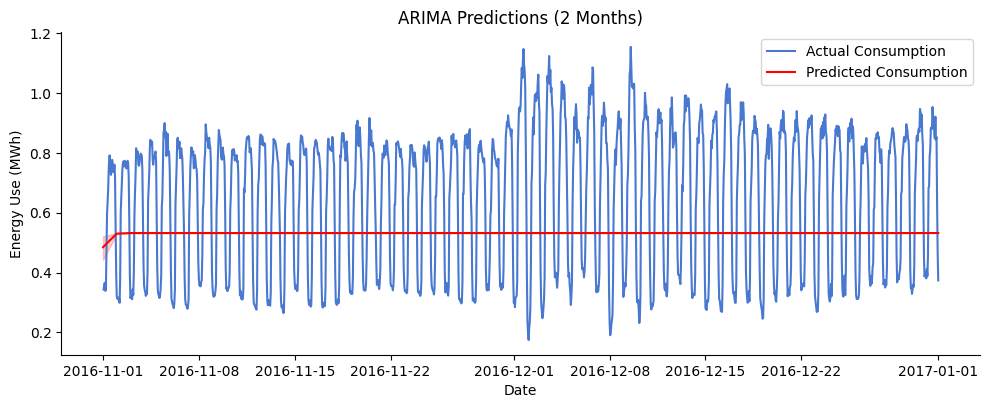

In [40]:
cons_test_2m = cons_test_2m.to_timestamp()
sns.relplot(x = cons_test_2m.index, y=cons_test_2m.values,
            kind = 'line', height = 4, aspect = 2.5,
            label="Actual Consumption").set(
                title="ARIMA Predictions (2 Months)",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")
sns.lineplot(predictions_arima_2m, color = 'red', label = 'Predicted Consumption')

In [41]:
# RMSE
import math
from sklearn.metrics import mean_squared_error

rmse_ar_2m = math.sqrt(mean_squared_error(cons_test, predictions_arima_2m))
rmse_ar_2m

0.26539232465274926

The ARIMA model does not perform very well, and can be taken as an equivalent to an baseline mean response.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: title={'center': 'ARIMA Predictions (1 Week)'}, xlabel='Date', ylabel='Energy Use (MWh)'>

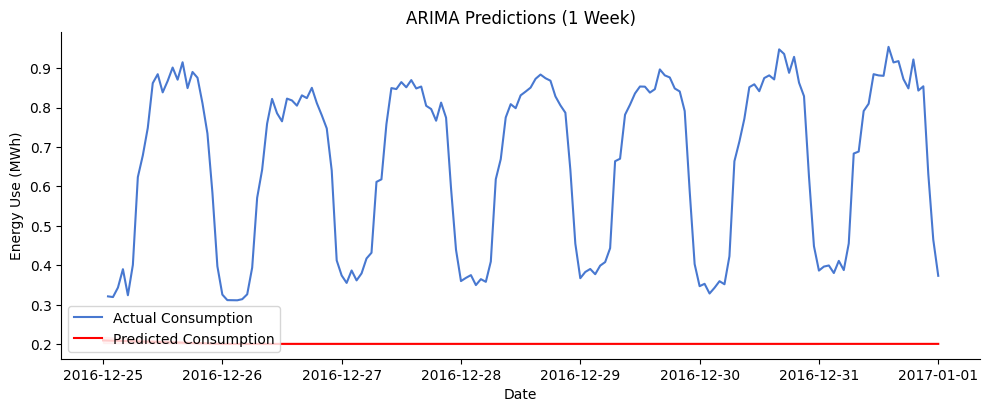

In [43]:
# Test data - last week

cons_train_1w = cons[:8616]
cons_test_1w = cons[8616:]

from statsmodels.tsa.arima.model import ARIMA

cons_train_1w.index = pd.DatetimeIndex(cons_train_1w.index).to_period('H')
cons_test_1w.index = pd.DatetimeIndex(cons_test_1w.index).to_period('H')

arima_model = ARIMA(cons_train_1w, order = (2,1,2))
pred = arima_model.fit()

pred.summary()

predictions_ar_1w = pred.predict(start = len(cons_train_1w),
                           end = len(cons_train_1w)+len(cons_test_1w) - 1,
                           typ = 'levels')

cons_test = cons_test_1w.to_timestamp()
sns.relplot(x = cons_test.index, y=cons_test.values,
            kind = 'line', height = 4, aspect = 2.5,
            label="Actual Consumption").set(
                title="ARIMA Predictions (1 Week)",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")
sns.lineplot(predictions_ar_1w, color = 'red', label = 'Predicted Consumption')

In [44]:
# RMSE
rmse_ar_1w = math.sqrt(mean_squared_error(cons_test, predictions_ar_1w))
rmse_ar_1w

0.5085025170434112

When the test set is changed to include just the last week of data, the performance of ARIMA model gets worse than the mean respones.

## SARIMA

The ARIMA model does not take into account the seasonality in the data. As the energy consumption goes up during the day, we need a seasonal ARIMA model to account for this seasonality. We follow the same procedure of finding the optimum parameters and testing the model on the test set.

In [45]:
# SARIMA Parameters using grid search
auto_arima(cons_train_2m,
           m = 24,
           start_p = 1,
           start_q = 1,
           max_p = 2,
           max_q = 2,
           start_P = 0,
           start_Q = 0,
           max_P = 1,
           max_Q = 1,
           trace = True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=-17207.026, Time=10.98 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-14774.523, Time=1.20 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=30.97 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=-19714.777, Time=32.89 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-14776.522, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=-16458.691, Time=2.30 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=62.70 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=-25162.318, Time=34.05 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=29.58 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=60.17 sec
 ARIMA(0,1,2)(1,0,0)[24] intercept   : AIC=-25293.603, Time=51.32 sec
 ARIMA(0,1,2)(0,0,0)[24] intercept   : AIC=-16930.444, Time=10.48 sec
 ARIMA(0,1,2)(1,0,1)[24] intercept   : AIC=-28206.737, Time=64.54 sec
 ARIMA(0,1,2)(0,0,1)[24] intercept   : AIC=-19958.364, Time=32.36 sec
 ARIMA(1

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 24),
      suppress_warnings=True)

In [46]:
# Developing SARIMAX model
cons_train_2m = cons[:7320]
cons_test_2m = cons[7320:]

model_sarimax = SARIMAX(cons_train_2m,
                order = (0, 1, 2), seasonal_order=(1, 0, 1, 24))

predictor = model_sarimax.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: title={'center': 'SARIMA Predictions (2 Months)'}, xlabel='Date', ylabel='Energy Use (MWh)'>

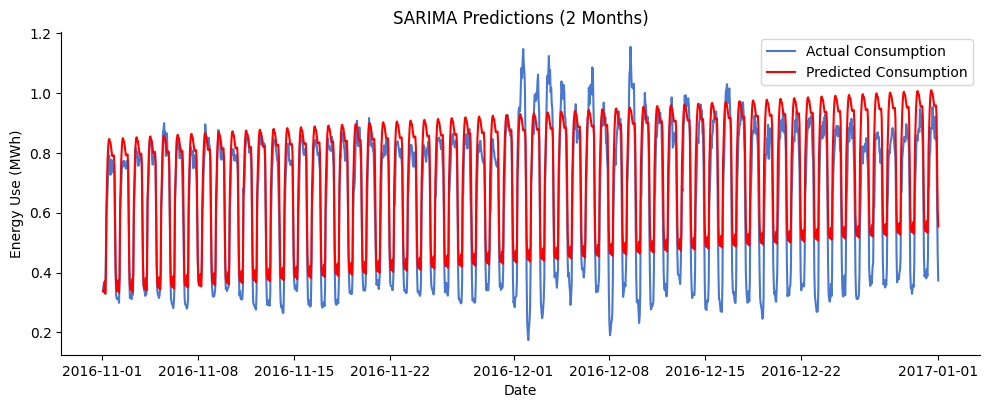

In [47]:
# Predictions and model evaluation
predictions_sar_2m = predictor.predict(start = len(cons_train_2m),
                                end = len(cons_train_2m) + len(cons_test_2m) - 1)


sns.relplot(x = cons_test_2m.index, y=cons_test_2m.values,
            kind = 'line', height = 4, aspect = 2.5,
            label="Actual Consumption").set(
                title="SARIMA Predictions (2 Months)",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")
sns.lineplot(predictions_sar_2m, color = 'red', label = 'Predicted Consumption')

In [49]:
rmse_sar_2m = math.sqrt(mean_squared_error(cons_test_2m, predictions_sar_2m))
rmse_sar_2m

0.10718666138925319

The seasonal ARIMA model performs better than the ARIMA model with no seasonality. But it still does not take into account for the variability in the data.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: title={'center': 'SARIMA Predictions (1 Week)'}, xlabel='Date', ylabel='Energy Use (MWh)'>

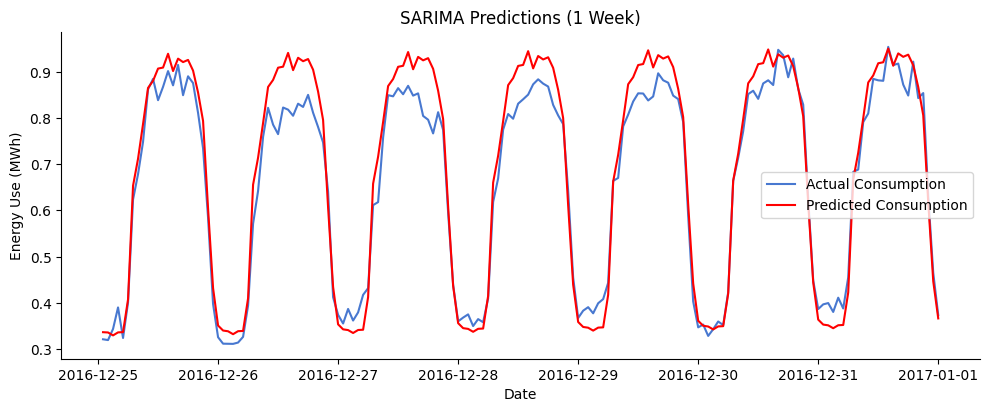

In [50]:
# Test - Last week
cons_train_1w = cons[:8616]
cons_test_1w = cons[8616:]

model_sarimax = SARIMAX(cons_train_1w,
                order = (0, 1, 2), seasonal_order=(1, 0, 1, 24))

predictor = model_sarimax.fit()

predictions_sar_1w = predictor.predict(start = len(cons_train_1w),
                                end = len(cons_train_1w) + len(cons_test_1w) - 1)


sns.relplot(x = cons_test_1w.index, y=cons_test_1w.values,
            kind = 'line', height = 4, aspect = 2.5,
            label="Actual Consumption").set(
                title="SARIMA Predictions (1 Week)",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")
sns.lineplot(predictions_sar_1w, color = 'red', label = 'Predicted Consumption')

In [51]:
# RMSE
import math
from sklearn.metrics import mean_squared_error

rmse_sar_1w = math.sqrt(mean_squared_error(cons_test, predictions_sar_1w))
rmse_sar_1w

0.05073721677323488

# Univariate LSTM

To account for the variability in the data, we model the time series data using the Long Short Term Memory (LSTM) model. In this LSTM model, we use a lookback period of 24 hours to predict the future values. We first fit a univariate LSTM model using just the hourly energy consumption values.

In [52]:
# Test set last two months
# Create a train and test set

train = df.iloc[:7320,0:1].values
test = df.iloc[7320:,0:1].values


from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0,1))

training_set_scaled = sc.fit_transform(train)
test_set_scaled = sc.fit_transform(test)

In [53]:
# Create Lookback
X_train = []
y_train = []
WS = 24

for i in range(WS, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-WS:i, 0:1])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [19]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [55]:
# Developing LSTM Model

Model_P = Sequential()

Model_P.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1],1)))
Model_P.add(Dropout(0.2))

Model_P.add(LSTM(units = 60, return_sequences = True))
Model_P.add(Dropout(0.2))

Model_P.add(LSTM(units = 60, return_sequences = True))
Model_P.add(Dropout(0.2))

Model_P.add(LSTM(units = 60))
Model_P.add(Dropout(0.2))

Model_P.add(Dense(units = 1))

Model_P.compile(optimizer = 'adam', loss = 'mean_squared_error')

Model_P.fit(X_train, y_train, epochs = 30, batch_size = 32, verbose = False)

In [56]:
# Prediction

prediction_test = []

Batch_one = training_set_scaled[-WS:]
Batch_New = Batch_one.reshape((1,WS,1))

for i in range(1464):
    First_Pred = Model_P.predict(Batch_New, verbose = 0)[0]
    prediction_test.append(First_Pred)
    Batch_New = np.append(Batch_New[:,1:,:], [[First_Pred]], axis = 1)

prediction_test = np.array(prediction_test)

predictions_lstm_2m = sc.inverse_transform(prediction_test)

<Axes: title={'center': 'LSTM Predictions (Univariate)'}, xlabel='Date', ylabel='Energy Use (MWh)'>

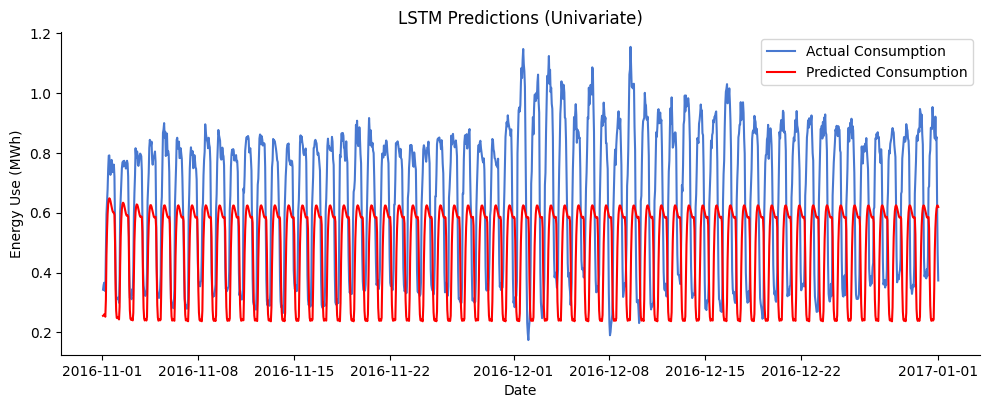

In [57]:
pred_data = pd.DataFrame(test, columns =['value'])
pred_data.set_index(df.iloc[7320:,].index,
                    inplace = True)

predictions_lstm_2m = pd.DataFrame(predictions_lstm_2m, columns = ['value'])
predictions_lstm_2m.set_index(df.iloc[7320:,].index,
                    inplace = True)

sns.relplot(y='value', x = pred_data.index, data=pred_data,
            kind = 'line', height = 4, aspect = 2.5,
            label="Actual Consumption").set(
                title="LSTM Predictions (Univariate)",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")
sns.lineplot(y = 'value', x = predictions_lstm_2m.index, data = predictions_lstm_2m,
             color = 'red', label = 'Predicted Consumption')

In [58]:
# RMSE
rmse_lstm_2m = math.sqrt(mean_squared_error(test, predictions_lstm_2m))
rmse_lstm_2m

0.32706409012528465

In [59]:
# Test Set: Last week
train = df.iloc[:8616,0:1].values
test = df.iloc[8616:,0:1].values


from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0,1))

training_set_scaled = sc.fit_transform(train)
test_set_scaled = sc.fit_transform(test)

X_train = []
y_train = []
WS = 24

for i in range(WS, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-WS:i, 0:1])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

Model_P = Sequential()

Model_P.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1],1)))
Model_P.add(Dropout(0.2))

Model_P.add(LSTM(units = 60, return_sequences = True))
Model_P.add(Dropout(0.2))

Model_P.add(LSTM(units = 60, return_sequences = True))
Model_P.add(Dropout(0.2))

Model_P.add(LSTM(units = 60))
Model_P.add(Dropout(0.2))

Model_P.add(Dense(units = 1))

Model_P.compile(optimizer = 'adam', loss = 'mean_squared_error')

Model_P.fit(X_train, y_train, epochs = 30, batch_size = 32, verbose=False)

prediction_test = []

Batch_one = training_set_scaled[-WS:]
Batch_New = Batch_one.reshape((1,WS,1))

for i in range(168):

    First_Pred = Model_P.predict(Batch_New, verbose = 0)[0]

    prediction_test.append(First_Pred)

    Batch_New = np.append(Batch_New[:,1:,:], [[First_Pred]], axis = 1)


prediction_test = np.array(prediction_test)

predictions_lstm_1w = sc.inverse_transform(prediction_test)

<Axes: title={'center': 'LSTM Predictions (Univariate, 1 Week)'}, xlabel='Date', ylabel='Energy Use (MWh)'>

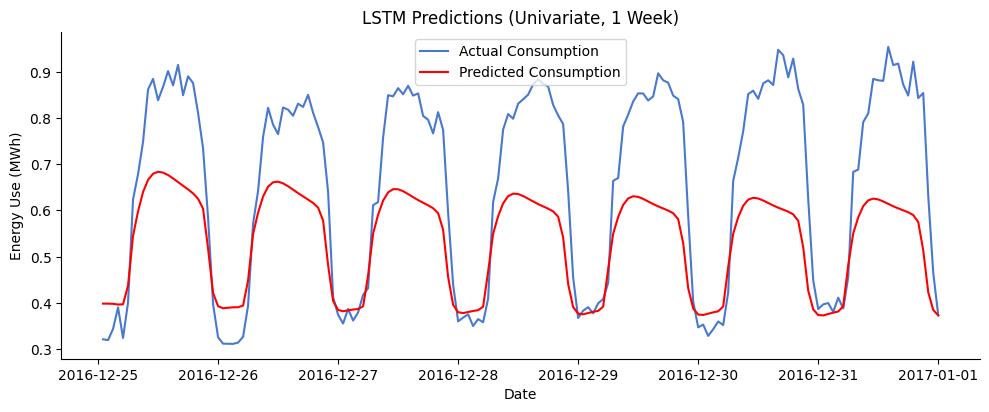

In [61]:
pred_data = pd.DataFrame(test, columns =['value'])
pred_data.set_index(df.iloc[8616:,].index,
                    inplace = True)

predictions_lstm_1w = pd.DataFrame(predictions_lstm_1w, columns = ['value'])
predictions_lstm_1w.set_index(df.iloc[8616:,].index,
                    inplace = True)

sns.relplot(y='value', x = pred_data.index, data=pred_data,
            kind = 'line', height = 4, aspect = 2.5,
            label="Actual Consumption").set(
                title="LSTM Predictions (Univariate, 1 Week)",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")
sns.lineplot(y = 'value', x = predictions_lstm_1w.index, data = predictions_lstm_1w,
             color = 'red', label = 'Predicted Consumption')

In [62]:
# RMSE
rmse_lstm_1w = math.sqrt(mean_squared_error(cons_test, predictions_lstm_1w))
rmse_lstm_1w

0.1762817722362707

The Univariate LSTM model does not perform better than the SARIMA model for both the test sets. The LSTM model also does not account for the variability in the data.

## Multivariate LSTM

In [63]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [64]:
# Create Training and test dataset

training_set = df.iloc[:8616, 0:2].values
test_set = df.iloc[8616:, 0:2].values

sc = MinMaxScaler(feature_range = (0,1))

training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.fit_transform(test_set)

test_set_scaled = test_set_scaled[:, 1:2]

In [65]:
# Create lookback (24H)

X_train = []
y_train = []
WS = 24

for i in range(WS, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-WS:i, 0:2])
    y_train.append(training_set_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 2))

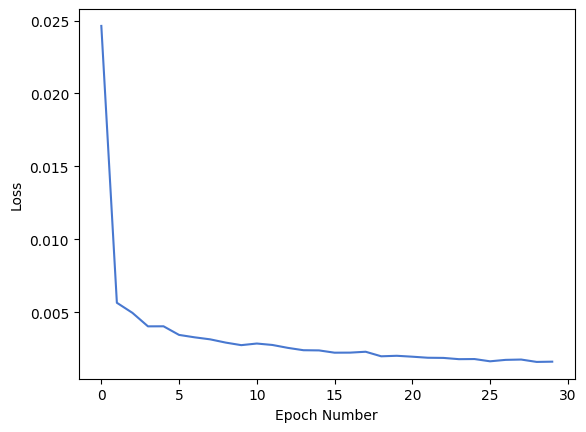

In [66]:
# Create LSTM Model

Model = Sequential()

Model.add(LSTM(units = 120, return_sequences = True, input_shape = (X_train.shape[1], 2)))
Model.add(Dropout(0.2))

Model.add(LSTM(units = 120, return_sequences = True))
Model.add(Dropout(0.2))

Model.add(LSTM(units = 120, return_sequences = True))
Model.add(Dropout(0.2))

Model.add(LSTM(units = 120))
Model.add(Dropout(0.2))

Model.add(Dense(units = 1))

Model.compile(optimizer = 'adam', loss = 'mean_squared_error')

Model.fit(X_train,y_train, epochs = 30, batch_size = 32, verbose = False)

plt.plot(range(len(Model.history.history['loss'])), Model.history.history['loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

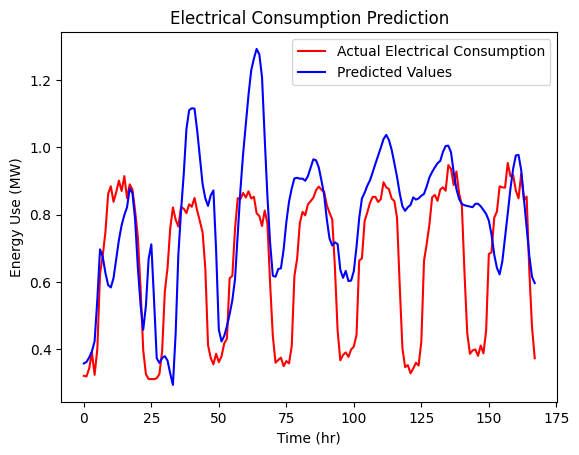

In [67]:
# Make predictions
prediction_test = []
Batch_one = training_set_scaled[-24:]
Batch_New = Batch_one.reshape((1,24,2))

for i in range(168):
    First_pred = Model.predict(Batch_New, verbose = 0)[0]
    prediction_test.append(First_pred)
    New_var = test_set_scaled[i,:]
    New_var = New_var.reshape(1,1)
    New_test = np.insert(New_var, 1, [First_pred], axis =1)
    New_test = New_test.reshape(1,1,2)
    Batch_New = np.append(Batch_New[:,1:,:], New_test, axis=1)

prediction_test = np.array(prediction_test)

SI = MinMaxScaler(feature_range = (0,1))
y_Scale = training_set[:,0:1]
SI.fit_transform(y_Scale)

predictions = SI.inverse_transform(prediction_test)

real_values = test_set[:, 0]

plt.plot(real_values, color = 'red', label = 'Actual Electrical Consumption')
plt.plot(predictions, color = 'blue', label = 'Predicted Values')
plt.title('Electrical Consumption Prediction')
plt.xlabel('Time (hr)')
plt.ylabel('Energy Use (MW)')
plt.legend()
plt.show()

<Axes: title={'center': 'LSTM Predictions (Multivariate, 1 Week)'}, xlabel='Date', ylabel='Energy Use (MWh)'>

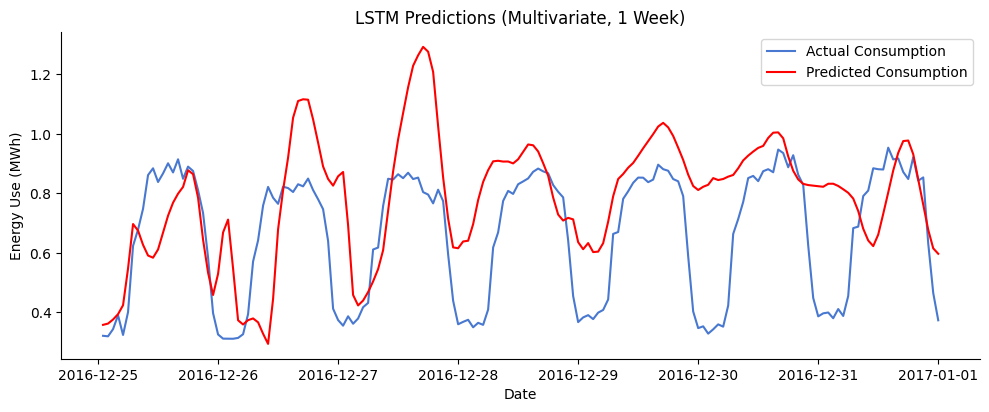

In [68]:
pred_data = pd.DataFrame(real_values, columns =['value'])
pred_data.set_index(df.iloc[8616:,].index,
                    inplace = True)

predictions = pd.DataFrame(predictions, columns = ['value'])
predictions.set_index(df.iloc[8616:,].index,
                    inplace = True)

sns.relplot(y='value', x = pred_data.index, data=pred_data,
            kind = 'line', height = 4, aspect = 2.5,
            label="Actual Consumption").set(
                title="LSTM Predictions (Multivariate, 1 Week)",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")
sns.lineplot(y = 'value', x = predictions.index, data = predictions,
             color = 'red', label = 'Predicted Consumption')

In [69]:
# RMSE
rmse_mlstm_1w = math.sqrt(mean_squared_error(cons_test, predictions))
rmse_mlstm_1w

0.2394851223717197

In [70]:
# Create Training and test dataset

training_set = df.iloc[:7320, 0:2].values
test_set = df.iloc[7320:, 0:2].values

sc = MinMaxScaler(feature_range = (0,1))

training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.fit_transform(test_set)

test_set_scaled = test_set_scaled[:, 1:2]

In [71]:
# Create lookback (24H)
X_train = []
y_train = []
WS = 24

for i in range(WS, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-WS:i, 0:2])
    y_train.append(training_set_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 2))

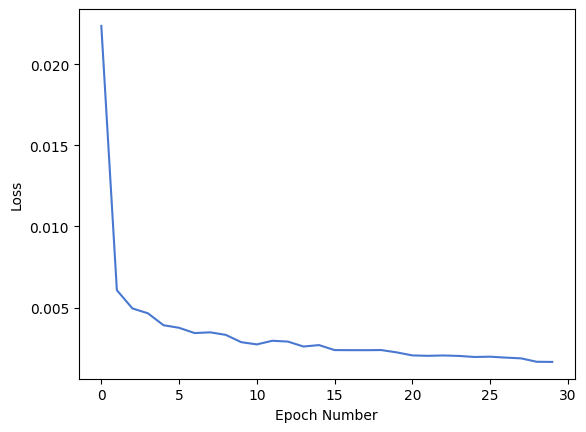

In [73]:
# Create LSTM Model

Model = Sequential()

Model.add(LSTM(units = 120, return_sequences = True, input_shape = (X_train.shape[1], 2)))
Model.add(Dropout(0.2))

Model.add(LSTM(units = 120, return_sequences = True))
Model.add(Dropout(0.2))

Model.add(LSTM(units = 120, return_sequences = True))
Model.add(Dropout(0.2))

Model.add(LSTM(units = 120))
Model.add(Dropout(0.2))

Model.add(Dense(units = 1))

Model.compile(optimizer = 'adam', loss = 'mean_squared_error')

Model.fit(X_train,y_train, epochs = 30, batch_size = 32, verbose = False)

plt.plot(range(len(Model.history.history['loss'])), Model.history.history['loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

In [74]:
# Make predictions
prediction_test = []
Batch_one = training_set_scaled[-24:]
Batch_New = Batch_one.reshape((1,24,2))

for i in range(1464):
    First_pred = Model.predict(Batch_New, verbose = 0)[0]
    prediction_test.append(First_pred)
    New_var = test_set_scaled[i,:]
    New_var = New_var.reshape(1,1)
    New_test = np.insert(New_var, 1, [First_pred], axis =1)
    New_test = New_test.reshape(1,1,2)
    Batch_New = np.append(Batch_New[:,1:,:], New_test, axis=1)

prediction_test = np.array(prediction_test)

SI = MinMaxScaler(feature_range = (0,1))
y_Scale = training_set[:,0:1]
SI.fit_transform(y_Scale)

predictions = SI.inverse_transform(prediction_test)

real_values = test_set[:, 0]

<Axes: title={'center': 'LSTM Predictions (Multivariate, 2 months)'}, xlabel='Date', ylabel='Energy Use (MWh)'>

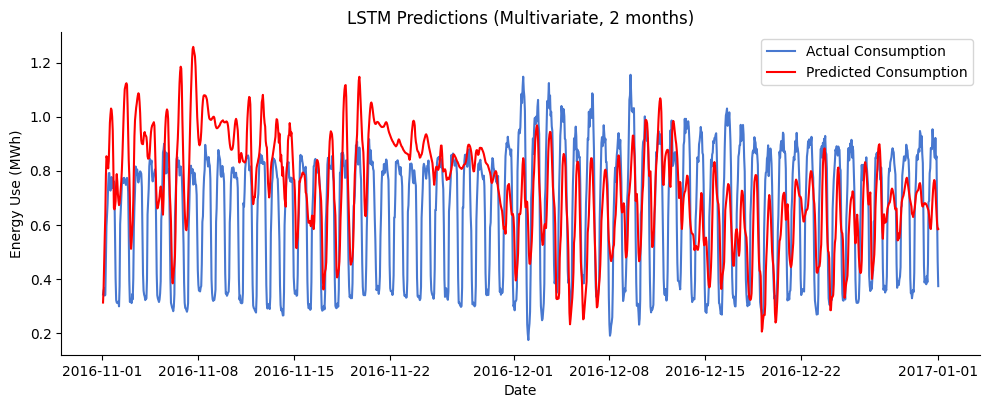

In [75]:
pred_data = pd.DataFrame(real_values, columns =['value'])
pred_data.set_index(df.iloc[7320:,].index,
                    inplace = True)

predictions = pd.DataFrame(predictions, columns = ['value'])
predictions.set_index(df.iloc[7320:,].index,
                    inplace = True)

sns.relplot(y='value', x = pred_data.index, data=pred_data,
            kind = 'line', height = 4, aspect = 2.5,
            label="Actual Consumption").set(
                title="LSTM Predictions (Multivariate, 2 months)",
                xlabel = "Date",
                ylabel = "Energy Use (MWh)")
sns.lineplot(y = 'value', x = predictions.index, data = predictions,
             color = 'red', label = 'Predicted Consumption')

In [76]:
rmse_mlstm_2m = math.sqrt(mean_squared_error(test_set[:,0], predictions))
rmse_mlstm_2m

0.2558389316149346

The Multivariate LSTM model performs worst than the univariate LSTM model. The SARIMA model has the least RMSE error among all the models considered.

## Conclusion

Among all the model considered to predict the energy usage with two different test sets, the SARIMA model performs better. The deep learning models can perform better with improved hyperparameter tuning.